# Building The General Model

Using the analysis created by the previous sections, we will try to build and solve the
general model for concurrency value autoscaling.


One important thing to note here is that the general model is evaluated every 2 seconds
because of the inherent autoscaling evaluation period of 2 seconds in knative. As a result
we need to convert the rates of provisioning and deprovisioning of containers from
time rates into probability rates (from CTMC to DTCM parameters).

In [1]:
%load_ext autoreload
%autoreload 2
# imports

# important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

from tqdm.auto import tqdm
import itertools

# for better printing of variables
from IPython.display import display

# custom imports
from concperf import single_model, general_model
from concperf import utility

In [2]:
# update configuration dictionary for each instance count
def update_config(config):
    config['arrival_rate_server'] = config['arrival_rate_total'] / config['instance_count']
    config['base_service_time'] = config['base_service_time_ms'] / 1000
    config['stable_conc_avg_count'] = 10 * config['instance_count']

# model_config = {
#     # 'instance_count' should be added for each state
#     'max_conc': 100,
#     'arrival_rate_total': 5,
#     'alpha': 0.11,
#     'base_service_time_ms': 1154,
#     'max_container_count': 25,
#     'target_conc': 0.7, # assumes target utilization
#     'max_scale_up_rate': 1000, # from N to 1000*N at most
#     'max_scale_down_rate': 2, # from N to N/2 at most
#     # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
#     'autoscaling_interval': 2, # amount of time between autoscaling evaluations
#     'provision_rate_base': 1,
#     'deprovision_rate_base': 2,
# }

# test
model_config = {
    # 'instance_count' should be added for each state
    'max_conc': 100,
    'arrival_rate_total': 15,
    'alpha': 1,
    'base_service_time_ms': 400,
    'max_container_count': 25,
    'target_conc': 16*0.7, # assumes target utilization
    'max_scale_up_rate': 1000, # from N to 1000*N at most
    'max_scale_down_rate': 2, # from N to N/2 at most
    # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
    'autoscaling_interval': 2, # amount of time between autoscaling evaluations
    'provision_rate_base': 1,
    'deprovision_rate_base': 2,
}

single_coder = single_model.StateCoder(config=model_config)

In [3]:
general_state_coder = general_model.StateCoder(model_config)
print('Number of states:', general_state_coder.get_state_count())
display(general_state_coder.get_state_list()[:10])

Number of states: 676


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9)]

In [4]:
probs = utility.get_trans_probs(10, transition_rate_base=1, max_t=model_config['autoscaling_interval'])
probs

array([1.52299797e-08, 8.75746755e-07, 2.23807806e-05, 3.33648146e-04,
       3.19754509e-03, 2.04292949e-02, 8.70159409e-02, 2.38264169e-01,
       3.80570786e-01, 2.70165344e-01])

In [5]:
# NOTE: This part assumes delay center to allow scalability
# TODO: Allow changing delay center to single server queue with config
display(general_model.get_trans_probabilities(ready_count=1, ordered_count=3, config=model_config))
display(general_model.get_trans_probabilities(ready_count=3, ordered_count=1, config=model_config))

(array([1, 2, 3]), array([0.01831564, 0.23403929, 0.74764507]))

(array([3, 2, 1]), array([3.35462628e-04, 3.59603525e-02, 9.63704185e-01]))

In [6]:
display(general_model.get_trans_probabilities(ready_count=1, ordered_count=0, config=model_config))
display(general_model.get_trans_probabilities(ready_count=1, ordered_count=25, config=model_config))

(array([1, 0]), array([0.01831564, 0.98168436]))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 array([1.42516408e-21, 2.18530879e-19, 1.60563695e-17, 7.52290333e-16,
        2.52337320e-14, 6.44878917e-13, 1.30471973e-11, 2.14352423e-10,
        2.91020802e-09, 3.30550796e-08, 3.16786137e-07, 2.57595469e-06,
        1.78294123e-05, 1.05150568e-04, 5.27852976e-04, 2.24832152e-03,
        8.08011692e-03, 2.42937978e-02, 6.03611699e-02, 1.21784495e-01,
        1.94521992e-01, 2.36726080e-01, 2.06244028e-01, 1.14583015e-01,
        3.05032212e-02]))

In [7]:
# find parameters for different configuration

# TODO: do something about instance count of zero

state_count = general_state_coder.get_state_count()
general_P = np.zeros((state_count, state_count))
inst_count_possible_values = list(range(0, model_config['max_container_count']+1))
inst_count_possible_values = np.array(inst_count_possible_values)

for ready_inst_count in tqdm(inst_count_possible_values):
    # add instance count to config
    model_config.update({
        'instance_count': max(ready_inst_count, 1), # for 0 ready containers, solve CC with single server
    })

    # update the config
    update_config(model_config)

    # calculate and show Q
    single_Q = single_model.get_single_container_q(single_coder, config=model_config)
    # display(pd.DataFrame(single_Q))

    req_count_prob = utility.solve_CTMC(single_Q)
    req_df = pd.DataFrame(data = {
        'req_count': [s[0] for s in single_coder.get_state_list()],
        'req_count_prob': req_count_prob,
    })

    # if 0 instances, any value for request count over 0 causes transition to 1 instances
    if ready_inst_count == 0:
        new_order_vals = [0, 1]
        new_order_probs_zero = req_df['req_count_prob'][req_df['req_count'] == 0][0]
        new_order_probs_one = 1 - new_order_probs_zero
        new_order_probs = [new_order_probs_zero, new_order_probs_one]
    else:
        # calculate measure concurrency distribution
        avg_count = model_config['stable_conc_avg_count']
        import time
        start_time = time.time()
        req_count_averaged_vals, req_count_averaged_probs = utility.get_averaged_distribution(vals=req_df['req_count'], probs=req_df['req_count_prob'], avg_count=avg_count)
        # print(f"new order calculation took {time.time() - start_time} seconds for {ready_inst_count} instances")

        # calculate probability of different ordered instance count
        new_order_vals, new_order_probs = general_model.get_new_order_dist(req_count_averaged_vals, req_count_averaged_probs, model_config)

    # plot the result
    # plt.figure(figsize=(8,4))
    # plt.bar(new_order_val, new_order_prob, width=1)

    # now calculate probs according to number of ordered instances
    for ordered_inst_count in inst_count_possible_values:
        # get idx of the "from" state
        from_state_idx = general_state_coder.to_idx(state=(ordered_inst_count, ready_inst_count))

        # calculate probability of number of ready instances
        next_ready_vals, next_ready_probs = general_model.get_trans_probabilities(ready_count=ready_inst_count, ordered_count=ordered_inst_count, config=model_config)

        # calculate probability for all combinations of "to" states
        for new_order_idx, next_ready_idx in itertools.product(range(len(new_order_vals)), range(len(next_ready_vals))):
            new_order_val = new_order_vals[new_order_idx]
            new_order_prob = new_order_probs[new_order_idx]
            next_ready_val = next_ready_vals[next_ready_idx]
            next_ready_prob = next_ready_probs[next_ready_idx]

            to_state_idx = general_state_coder.to_idx(state=(new_order_val, next_ready_val))
            general_P[from_state_idx, to_state_idx] = new_order_prob * next_ready_prob

100%|██████████| 26/26 [01:04<00:00,  2.48s/it]


In [8]:
# when everything is fixed, this should all be ones (almost, because of rounding errors)
display(np.where((general_P.sum(axis=1)-1) > 1e-6))
# we don't want to be stuck in a specific state
display(np.where(general_P == 1))

(array([], dtype=int64),)

(array([0], dtype=int64), array([26], dtype=int64))

<BarContainer object of 26 artists>

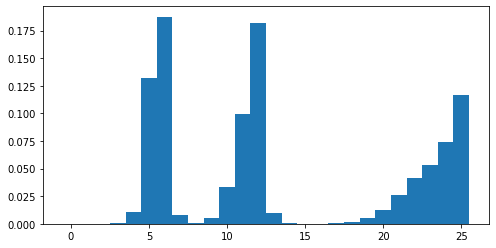

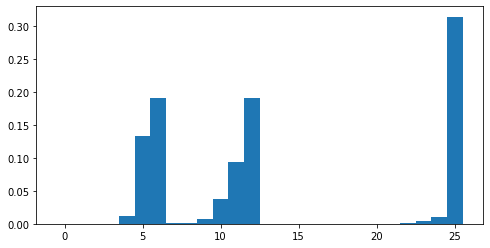

In [9]:
inst_count_probs = utility.solve_DTMC(general_P)
ready_probs = inst_count_probs.reshape((len(inst_count_possible_values),-1)).sum(axis=0)
ordered_probs = inst_count_probs.reshape((len(inst_count_possible_values),-1)).sum(axis=1)
plt.figure(figsize=(8,4))
plt.bar(inst_count_possible_values, ready_probs, width=1)
plt.figure(figsize=(8,4))
plt.bar(inst_count_possible_values, ordered_probs, width=1)